# Focus: Symmetry

In [1]:
import kagglehub
import pandas as pd # to work with dataframes, manipulate data (panel data)
import matplotlib.pyplot as plt # viz library
import seaborn as sns # HD viz library
import numpy as np # to work with numbers (numerical python)
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
from scipy.stats import pearsonr

%matplotlib inline
pd.set_option('display.max_columns', None)

data = pd.read_csv(r'cleaned_data.csv')
df = data.copy()


c:\ProgramData\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Specifying only symmetry related columns

In [2]:
df_symmetry = df[['id', 'diagnosis','symmetry_mean', 'symmetry_se', 'symmetry_worst' ]]

### Defining a new value column

Idea: Add a new value for the difference between mean symmetry and symmetry at worst to explore possible correlation focusing the change of size

In [3]:
# defining a new measure for the difference between the mean and the worst symmetry
df_symmetry = df_symmetry.assign( symmetry_diff = lambda x: (x['symmetry_worst'] - x['symmetry_mean'] ))
df_symmetry

id diagnosis  symmetry_mean  symmetry_se  symmetry_worst  \
0      842302         M         0.2419      0.03003          0.4601   
1      842517         M         0.1812      0.01389          0.2750   
2    84300903         M         0.2069      0.02250          0.3613   
3    84348301         M         0.2597      0.05963          0.6638   
4    84358402         M         0.1809      0.01756          0.2364   
..        ...       ...            ...          ...             ...   
564    926424         M         0.1726      0.01114          0.2060   
565    926682         M         0.1752      0.01898          0.2572   
566    926954         M         0.1590      0.01318          0.2218   
567    927241         M         0.2397      0.02324          0.4087   
568     92751         B         0.1587      0.02676          0.2871   

     symmetry_diff  
0           0.2182  
1           0.0938  
2           0.1544  
3           0.4041  
4           0.0555  
..             ...  
564         0.0334  
565         0.0820  
566         0.0628  
567         0.1690  
568         0.1284  

[569 rows x 6 columns]

In [4]:
# filtering the DataFrame by diagnosis
df_M = df_symmetry[df_symmetry['diagnosis'] == 'M']
df_B = df_symmetry[df_symmetry['diagnosis'] == 'B']

Variable for plots

In [5]:
# symmetry variables to analyze
symmetry_vars = ['symmetry_mean', 'symmetry_se', 'symmetry_worst', 'symmetry_diff']

### Symmetry histograms and overview

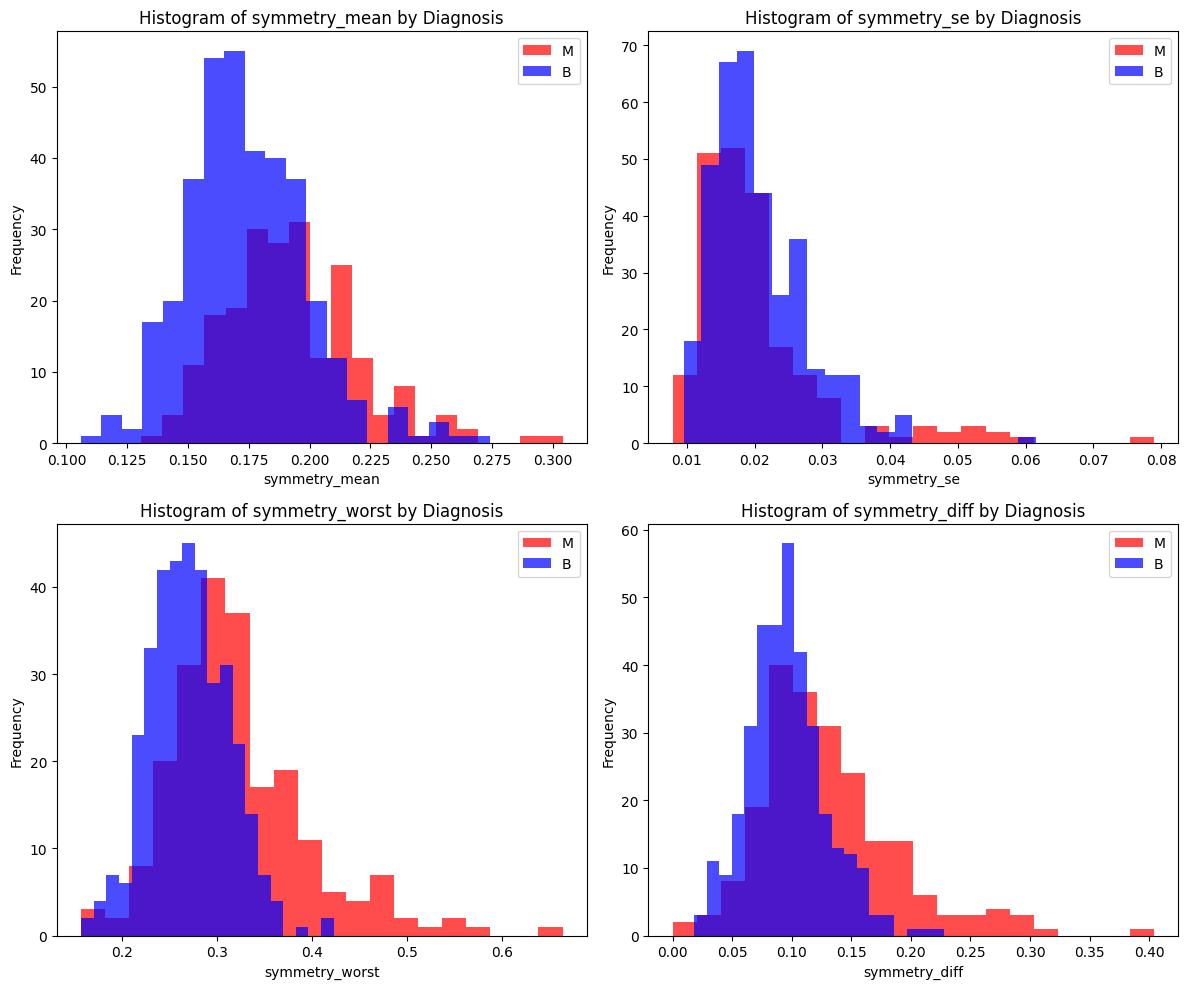

In [6]:
# 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# loop through each symmetry variable and plot overlapping histograms for "M" and "B"
for i, var in enumerate(symmetry_vars):
    ax = axes[i // 2, i % 2]
    # filtering data by diagnosis
    data_M = df_symmetry[df_symmetry['diagnosis'] == 'M'][var]
    data_B = df_symmetry[df_symmetry['diagnosis'] == 'B'][var]
    
    # plot overlapping histograms with same style and colors:
    # diagnosis M in red and diagnosis B in blue, with alpha=0.7
    ax.hist(data_M, bins=20, alpha=0.7, label='M', color='red')
    ax.hist(data_B, bins=20, alpha=0.7, label='B', color='blue')
    
    ax.set_title(f"Histogram of {var} by Diagnosis")
    ax.set_xlabel(var)
    ax.set_ylabel("Frequency")
    ax.legend()

plt.tight_layout()
plt.savefig('plots/histo_symmetry.png')
plt.show()


### Closer look at the overlapping regions

In [7]:
#  2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
axes = axes.flatten()

# loop over each symmetry variable
for i, var in enumerate(symmetry_vars):
    
    # determine the overlapping range for the variable
    min_overlap = max(df_M[var].min(), df_B[var].min())
    max_overlap = min(df_M[var].max(), df_B[var].max())
    
    # filter the DataFrame to the overlapping region
    df_overlap = df_symmetry[(df_symmetry[var] >= min_overlap) & (df_symmetry[var] <= max_overlap)].copy()
    
    # create 10 evenly spaced bins in the overlapping range
    bins = np.linspace(min_overlap, max_overlap, 11)
    df_overlap[var + '_bin'] = pd.cut(df_overlap[var], bins=bins, include_lowest=True)
    
    # calculate counts for each bin and the probability of diagnosis "M"
    bin_counts = df_overlap.groupby(var + '_bin')['diagnosis'].count()
    prob_cancer = df_overlap.groupby(var + '_bin')['diagnosis'].apply(lambda x: (x == 'M').sum() / len(x))
    print(prob_cancer)

    # Calculate bin centers and bin width
    bin_centers = [interval.mid for interval in bin_counts.index.categories]
    bin_width = bins[1] - bins[0]
    
    # plot on the current subplot
    ax = axes[i]
    # histogram (bar chart) for counts on primary y-axis (blue)
    ax.bar(bin_centers, bin_counts, width=bin_width, alpha=0.5, color='blue', label='Count')
    ax.set_xlabel(f"{var} (Overlapping Range)")
    ax.set_ylabel("Count", color='blue')
    ax.tick_params(axis='y', labelcolor='blue')
    ax.set_title(f"Overlap & Cancer Probability vs {var}")
    
    # create a secondary y-axis for the probability curve (red)
    ax2 = ax.twinx()
    ax2.plot(bin_centers, prob_cancer.values, marker='o', linestyle='-', color='red', label='Prob. of Cancer (M)')
    ax2.set_ylabel("Probability of Cancer (M)", color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    

    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.savefig('plots/histo_overlap_symmetry.png')
plt.show()


C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_6992\4027243767.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = df_overlap.groupby(var + '_bin')['diagnosis'].count()
C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_6992\4027243767.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_cancer = df_overlap.groupby(var + '_bin')['diagnosis'].apply(lambda x: (x == 'M').sum() / len(x))
C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_6992\4027243767.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cu

symmetry_mean_bin
(0.13, 0.145]     0.100000
(0.145, 0.16]     0.235294
(0.16, 0.174]     0.232000
(0.174, 0.188]    0.413793
(0.188, 0.203]    0.420000
(0.203, 0.217]    0.649123
(0.217, 0.231]    0.761905
(0.231, 0.246]    0.615385
(0.246, 0.26]     0.500000
(0.26, 0.274]     0.666667
Name: diagnosis, dtype: float64
symmetry_se_bin
(0.008539999999999999, 0.0147]    0.459677
(0.0147, 0.0199]                  0.358491
(0.0199, 0.0251]                  0.369369
(0.0251, 0.0303]                  0.234375
(0.0303, 0.0355]                  0.200000
(0.0355, 0.0407]                  0.444444
(0.0407, 0.0459]                  0.375000
(0.0459, 0.0511]                  1.000000
(0.0511, 0.0563]                  1.000000
(0.0563, 0.0615]                  0.666667
Name: diagnosis, dtype: float64
symmetry_worst_bin
(0.156, 0.183]    0.250000
(0.183, 0.21]     0.133333
(0.21, 0.236]     0.164179
(0.236, 0.263]    0.198113
(0.263, 0.29]     0.304000
(0.29, 0.316]     0.393939
(0.316, 0.343]    0.4

### Boxplot overview of 4 symmetry metrics

C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_6992\1098097945.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='diagnosis', y=var, data=df_symmetry,
C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_6992\1098097945.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='diagnosis', y=var, data=df_symmetry,
C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_6992\1098097945.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='diagnosis', y=var, data=df_symmetry,
C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_6992\1098097945.py:8: FutureWarning: 

Pass

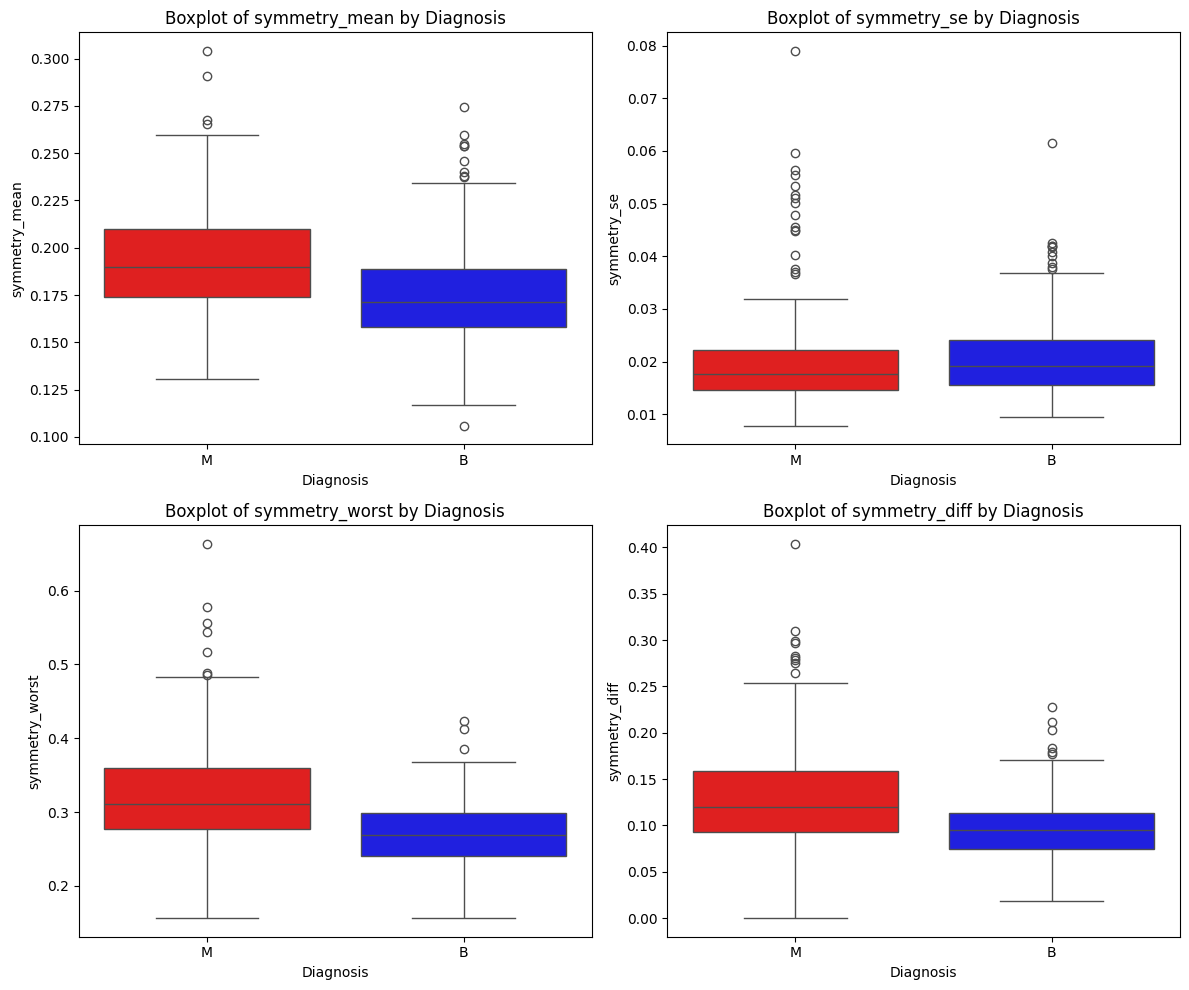

In [8]:
# create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # flatten the axes array so each element is an Axes instance

# loop over each variable and generate a boxplot
for i, var in enumerate(symmetry_vars):
    ax = axes[i]
    sns.boxplot(x='diagnosis', y=var, data=df_symmetry,
                palette={'M': 'red', 'B': 'blue'}, ax=ax)
    ax.set_title(f"Boxplot of {var} by Diagnosis")
    ax.set_xlabel("Diagnosis")
    ax.set_ylabel(var)

plt.tight_layout()
plt.savefig('plots/boxplt_symmetry.png')
plt.show()


### Pearson's correlation for symmetry_mean, symmetry_se, symmetry_worst and symmetry_diff with diagnosis

In [9]:
df_symmetry['diagnosis_numeric'] = df_symmetry['diagnosis'].map({'B': 0, 'M': 1})

# dictionary for correlation results
results = {}

for col in symmetry_vars:
    r, p = pearsonr(df_symmetry['diagnosis_numeric'], df_symmetry[col])
    results[col] = {'p-value': p, 'r-Pearson': r}

results_df = pd.DataFrame(results).T
print(results_df)


                     p-value  r-Pearson
symmetry_mean   5.733384e-16   0.330499
symmetry_se     8.766418e-01  -0.006522
symmetry_worst  2.951121e-25   0.416294
symmetry_diff   2.152939e-18   0.355509


symmetry difference and max(_worst) show the closest to 0 values, indicating strong correlation

### Chi-Square for the overlapping region for diagnosis and symmetry at worst

Let's pick the symmetry metric with the smallest p-value and calculate its Chi-Square p-value.

Since the symmetry is a continues numeric data, first converting it into discrete values within the overlapping region using binning technique and then calculating p-value of Chi-Square

In [10]:
# determining overlapping range
min_overlap = max(df_M['symmetry_worst'].min(), df_B['symmetry_worst'].min())
max_overlap = min(df_M['symmetry_worst'].max(), df_B['symmetry_worst'].max())

df_overlap = df_symmetry[(df_symmetry['symmetry_worst'] >= min_overlap) & (df_symmetry['symmetry_worst'] <= max_overlap)]

# bins for the overlapping region (10 bins)
bins = np.linspace(min_overlap, max_overlap, 11)
df_overlap = df_overlap.copy()  # avoid SettingWithCopyWarning
df_overlap['symmetry_bin'] = pd.cut(df_overlap['symmetry_worst'], bins=bins, include_lowest=True)


contingency_table = pd.crosstab(df_overlap['symmetry_bin'], df_overlap['diagnosis'])
print(contingency_table)


_,pvalue, _, _ = chi2_contingency(contingency_table)
cramer_v = association(contingency_table, method='cramer')
print(f'Chi-Square p-value is {pvalue}\nCramer V is: {cramer_v}')


diagnosis        B   M
symmetry_bin          
(0.156, 0.183]   6   2
(0.183, 0.21]   13   2
(0.21, 0.236]   56  11
(0.236, 0.263]  85  21
(0.263, 0.29]   87  38
(0.29, 0.316]   60  39
(0.316, 0.343]  36  33
(0.343, 0.37]   11  24
(0.37, 0.396]    1   9
(0.396, 0.423]   2  11
Chi-Square p-value is 8.699304311752277e-13
Cramer V is: 0.37351038131963304


Since the p-value for symmetry at worst is so big(much gerater than 0.05), it won't be considered when reviewing overlap cases.